In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import scipy
import sklearn

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [105]:
pd.set_option('display.max_rows', 9000)

In [106]:
noise_data = pd.read_csv("C:/Users/Axl Wynants/MDA-Georgia/Data/hourly_noisedata_2022.csv", header = 0, sep=',')
noise_data.head()

,month,day,hour,description,lamax,laeq
0,1,1,0,MP 03: Naamsestraat 62 Taste,60.322528,57.126833
1,1,1,0,MP 05: Calvariekapel KU Leuven,53.230972,49.987639
2,1,1,0,MP 06: Parkstraat 2 La Filosovia,53.666056,50.752000
3,1,1,0,MP 07: Naamsestraat 81,50.056861,47.440222
4,1,1,1,MP 03: Naamsestraat 62 Taste,53.033583,50.853806


In [107]:
noise_data = noise_data[noise_data["description"] == "MP 03: Naamsestraat 62 Taste"]
print(noise_data)
#Just location 3 for now

       month  day  hour                   description      lamax       laeq
0          1    1     0  MP 03: Naamsestraat 62 Taste  60.322528  57.126833
4          1    1     1  MP 03: Naamsestraat 62 Taste  53.033583  50.853806
8          1    1     2  MP 03: Naamsestraat 62 Taste  52.173702  50.049903
12         1    1     3  MP 03: Naamsestraat 62 Taste  50.821311  48.964907
16         1    1     4  MP 03: Naamsestraat 62 Taste  49.134851  47.285893
20         1    1     5  MP 03: Naamsestraat 62 Taste  49.447680  47.538650
24         1    1     6  MP 03: Naamsestraat 62 Taste  47.425444  46.146806
28         1    1     7  MP 03: Naamsestraat 62 Taste  47.807917  46.299889
32         1    1     8  MP 03: Naamsestraat 62 Taste  47.407583  46.047583
36         1    1     9  MP 03: Naamsestraat 62 Taste  47.685861  46.281444
40         1    1    10  MP 03: Naamsestraat 62 Taste  49.305611  47.921917
44         1    1    11  MP 03: Naamsestraat 62 Taste  51.117028  49.678472
48         1

In [7]:
noise_month = noise_data[noise_data["month"] == 3]  
noise_day = noise_month[noise_month["day"] == 27]
len(noise_day)

23

In [108]:
weather_data = pd.read_csv("C:/Users/Axl Wynants/MDA-Georgia/Data/hourly_weatherdata_2022.csv", header = 0, sep=',')
weather_data.head()

,Month,Day,Hour,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_TEMP_QCL3
0,1,1,0,0.000003,0.00036,-18.197324,0.389565,13.100358
1,1,1,1,0.000007,0.00000,-16.227891,0.222602,12.669197
2,1,1,2,0.000009,0.00000,-13.710884,0.217194,12.520271
3,1,1,3,0.000000,0.00000,-16.401361,0.178248,12.386194
4,1,1,4,0.000000,0.00000,-10.268707,0.237670,12.080706


In [115]:
noise_series = pd.Series(noise_data['laeq'])
temp_series = pd.Series(weather_data['LC_TEMP_QCL3'])
rain_series = pd.Series(weather_data['LC_DAILYRAIN'])
rain_cumul_series = pd.Series(weather_data['LC_RAININ'])
windspeed_series = pd.Series(weather_data['LC_WINDSPEED'])

In [10]:
len(noise_series)

8759

In [11]:
len(temp_series)

8760

In [12]:
len(rain_series)

8760

In [116]:
#Forward impute single observation in noise series on March 27 2AM
noise_series.loc[9430] = 50.700694
noise_series = noise_series.sort_index()
noise_series = noise_series.reset_index().drop('index', axis = 1)
print(noise_series)

           laeq
0     57.126833
1     50.853806
2     50.049903
3     48.964907
4     47.285893
5     47.538650
6     46.146806
7     46.299889
8     46.047583
9     46.281444
10    47.921917
11    49.678472
12    50.390556
13    50.540889
14    52.116306
15    51.707889
16    52.060861
17    53.191917
18    53.386389
19    52.455083
20    51.602500
21    50.681222
22    49.655333
23    47.838000
24    46.867665
25    45.862972
26    45.516667
27    45.024028
28    44.687306
29    45.059139
30    45.855639
31    47.074306
32    47.965472
33    49.448333
34    49.157766
35    51.837406
36    52.713083
37    52.321694
38    52.443778
39    51.608972
40    51.808833
41    55.216667
42    56.156556
43    57.824694
44    55.235556
45    53.492917
46    51.335306
47    47.688056
48    46.224639
49    45.886306
50    45.069417
51    44.824250
52    45.137583
53    45.702611
54    50.850139
55    52.611806
56    52.940694
57    53.380639
58    53.510083
59    54.804694
60    55.856667
61    58

In [117]:
#Day of week one hot encoding. Go for 24 hours, skip 120. Year starts on a saturday
lst = [6, 7, 1, 2, 3, 4, 5]
lst_new = list(np.repeat(lst,24))
lst_newnew = lst_new * 53
day = np.array(lst_newnew[0:8760])

weekday = pd.get_dummies(day, prefix=['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri'])
features = pd.concat([weekday, temp_series, rain_series, rain_cumul_series, windspeed_series], axis=1)

In [14]:
np.corrcoef(noise_series, temp_series)
#Positively correlated with temperature as expected

array([[1.        , 0.22365862],
       [0.22365862, 1.        ]])

In [15]:
np.corrcoef(noise_series, rain_series)
#Positively correlated with rain?

array([[1.        , 0.17214263],
       [0.17214263, 1.        ]])

In [16]:
np.corrcoef(noise_series, rain_cumul_series)

array([[1.        , 0.07950235],
       [0.07950235, 1.        ]])

In [17]:
np.corrcoef(noise_series, windspeed_series) 
#ofc more wind more noise

array([[1.        , 0.20323506],
       [0.20323506, 1.        ]])

In [127]:
#Lagged crosscorrelation with temp
crosscor = sm.tsa.stattools.ccf(temp_series, noise_series, adjusted=False)
print(crosscor[0:50])

[ 0.22365862  0.2142166   0.18724367  0.14290011  0.08436395  0.01643265
 -0.05418668 -0.12136306 -0.18019974 -0.22598216 -0.25540294 -0.26608084
 -0.25772045 -0.2319899  -0.19258968 -0.14379399 -0.09017662 -0.03540677
  0.01834559  0.06954472  0.1156653   0.15515311  0.18634794  0.20717762
  0.2146224   0.20541942  0.17815155  0.13357491  0.07503406  0.0072108
 -0.06373958 -0.13152592 -0.19092213 -0.23744135 -0.26756308 -0.27866947
 -0.27017309 -0.24418608 -0.20441847 -0.15518905 -0.10128307 -0.04654117
  0.00679964  0.05724626  0.10308905  0.14229216  0.17360959  0.1946576
  0.20228387  0.19351143]


In [128]:
#Lagged crosscorrelation with rain
crosscor = sm.tsa.stattools.ccf(rain_series, noise_series, adjusted=False)
print(crosscor[0:50])

[ 0.17214263  0.17982325  0.17603795  0.16421999  0.14329122  0.11909052
  0.09682295  0.07484539  0.05002924  0.02044498 -0.01157186 -0.04355385
 -0.07342476 -0.09890932 -0.1213651  -0.13337976 -0.12660959 -0.09745228
 -0.05530641 -0.01112555  0.03049002  0.06640684  0.09667412  0.11776471
  0.13137859  0.13642016  0.13184591  0.11946939  0.09952919  0.07778231
  0.05516712  0.03244995  0.00893798 -0.01580532 -0.04162226 -0.06694264
 -0.09051169 -0.11061532 -0.12661013 -0.13479366 -0.127126   -0.09900248
 -0.05700455 -0.01170359  0.03092194  0.06754651  0.09709388  0.11530865
  0.12625662  0.13087008]


In [118]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(features, noise_series,
    test_size=0.2)

#Convert target variables to 1D arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [ ]:
#'sun': sun, 'mon': mon, 'tue': tue, 'wed': wed, 'tue': tue, 'fri': fri

In [119]:
#Random forest
model = RandomForestRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [120]:
#Random forest evaluation
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)


Mean Squared Error (MSE): 6.773273999871153
Mean Absolute Error (MAE): 1.950806178567323
R-squared Score (R2): 0.5341068179040376


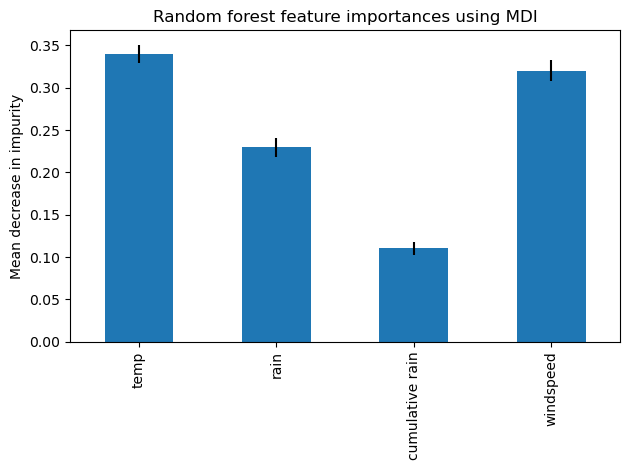

In [47]:
#Feature importance
importances = model.feature_importances_

forest_importances = pd.Series(importances, index=['temp', 'rain', 'cumulative rain', 'windspeed'])
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Random forest feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [25]:
#Try to improve the model with small grid search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [32]:
#Evaluate grid-search fitted rf
predictions1 = best_model.predict(X_test)

mse = mean_squared_error(y_test, predictions1)
mae = mean_absolute_error(y_test, predictions1)
r2 = r2_score(y_test, predictions1)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)
#Actually much better but need more computational power to do a proper search

Mean Squared Error (MSE): 8.89752812729372
Mean Absolute Error (MAE): 2.276941565491747
R-squared Score (R2): 0.3991628496671723
